In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [6]:
drivers = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_Drivers/Drivers'
pts = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_PTS/PTS'
passports = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_Passports/Passports'
sts = '/kaggle/input/gagarin-data/GAGARIN_DATASET/P_STS/STS'

In [81]:
file_name = drivers + '/v_0716_422768-1.png'

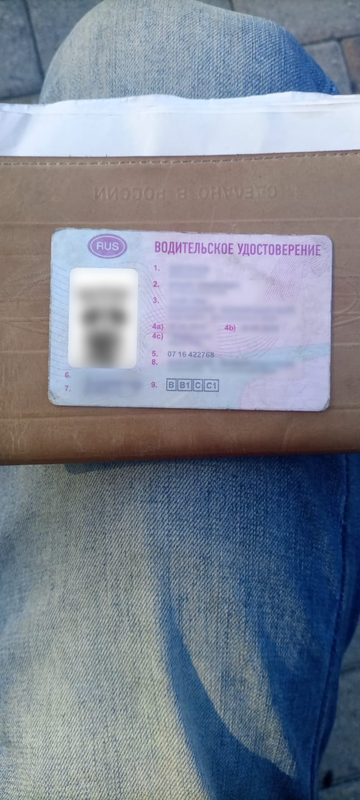

In [82]:
img = Image.open(file_name)
img.thumbnail((800,800), Image.ANTIALIAS)
img

In [83]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [16]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [17]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [84]:
image = cv2.imread(file_name)

resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

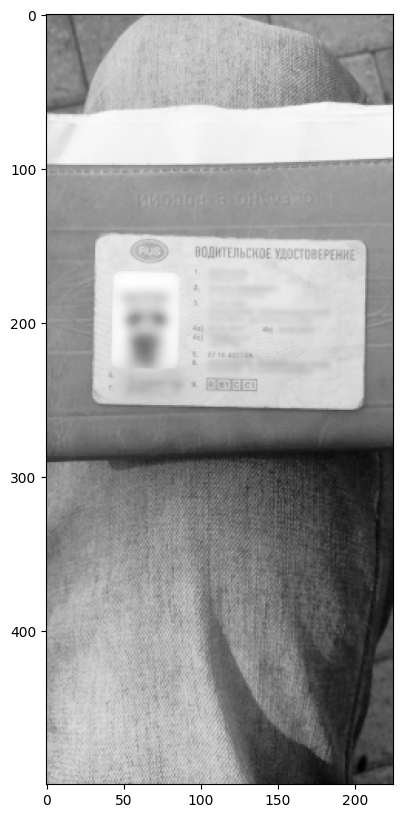

In [85]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

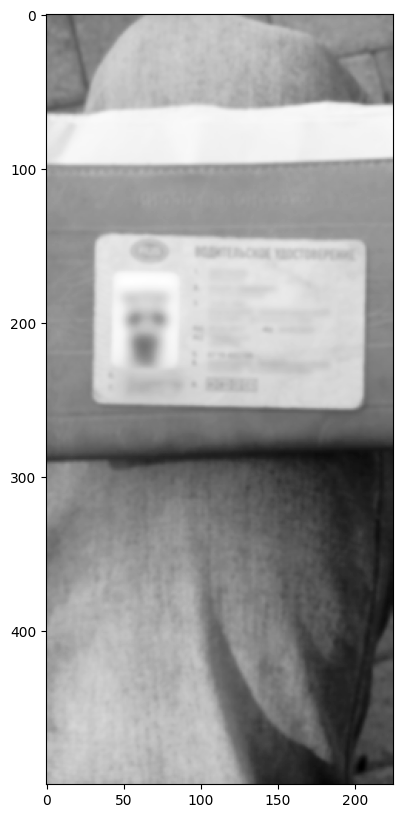

In [86]:
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

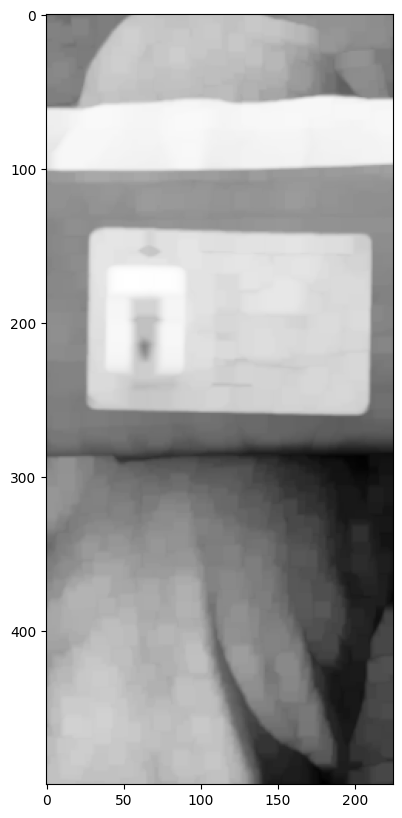

In [87]:
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

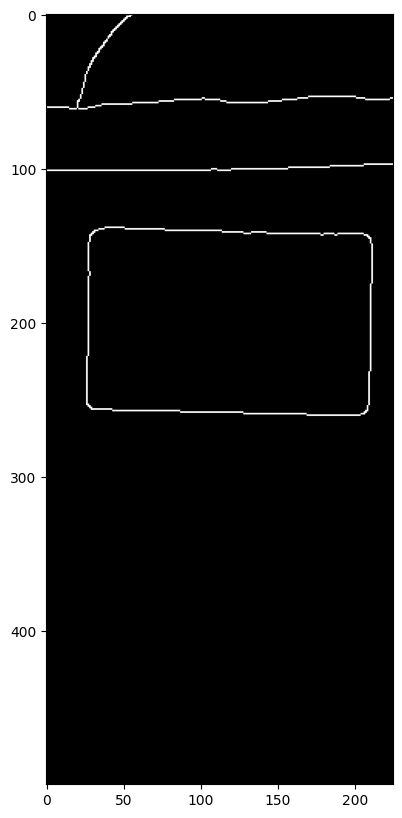

In [88]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plot_gray(edged)

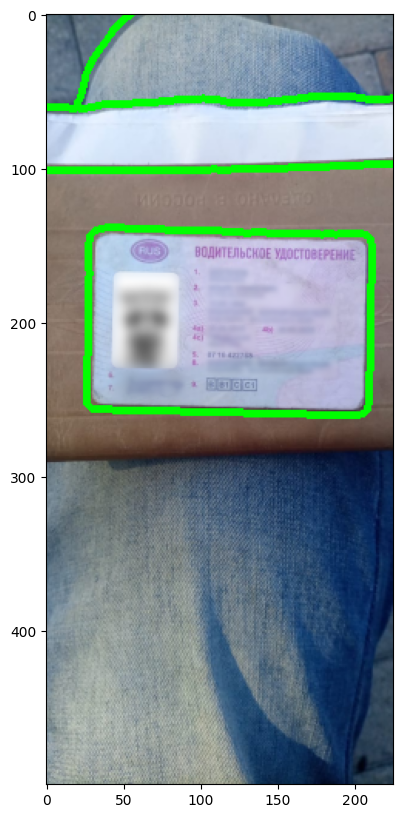

In [89]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

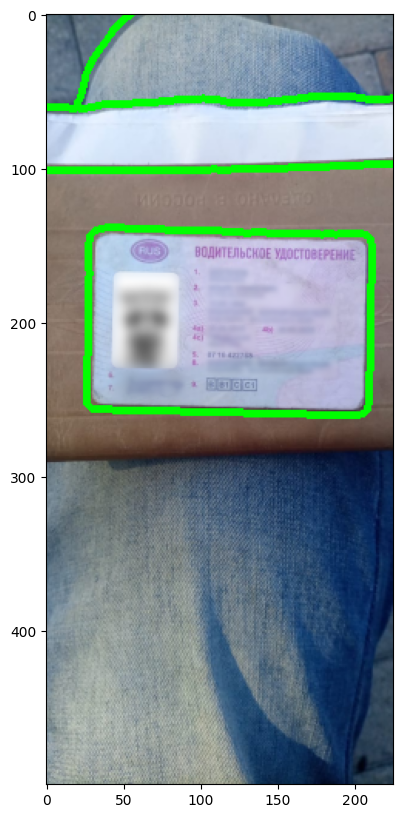

In [90]:
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [91]:
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [92]:
def get_contour(contours):    
    for c in contours:
        approx = approximate_contour(c)
        if len(approx) == 4:
            return approx

In [93]:
get_contour(largest_contours)

array([[[ 28, 143]],

       [[ 29, 256]],

       [[208, 257]],

       [[208, 143]]], dtype=int32)

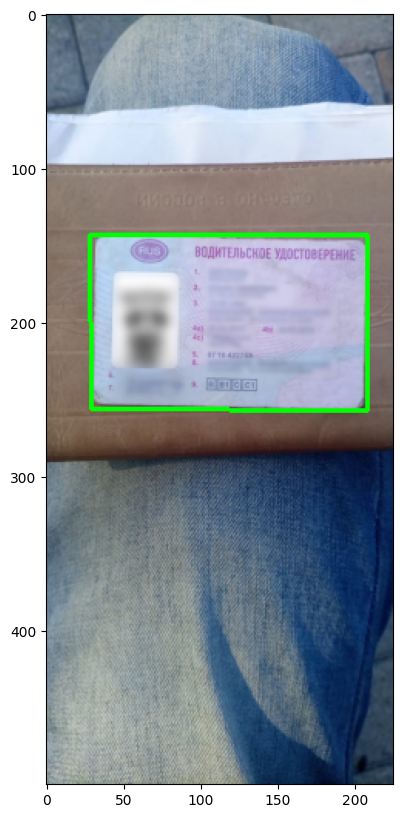

In [94]:
contour = get_contour(largest_contours)
image_with_contour = cv2.drawContours(image.copy(), [contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_contour)

In [96]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect / resize_ratio

In [97]:
def wrap_perspective(img, rect):
    (tl, tr, br, bl) = rect
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

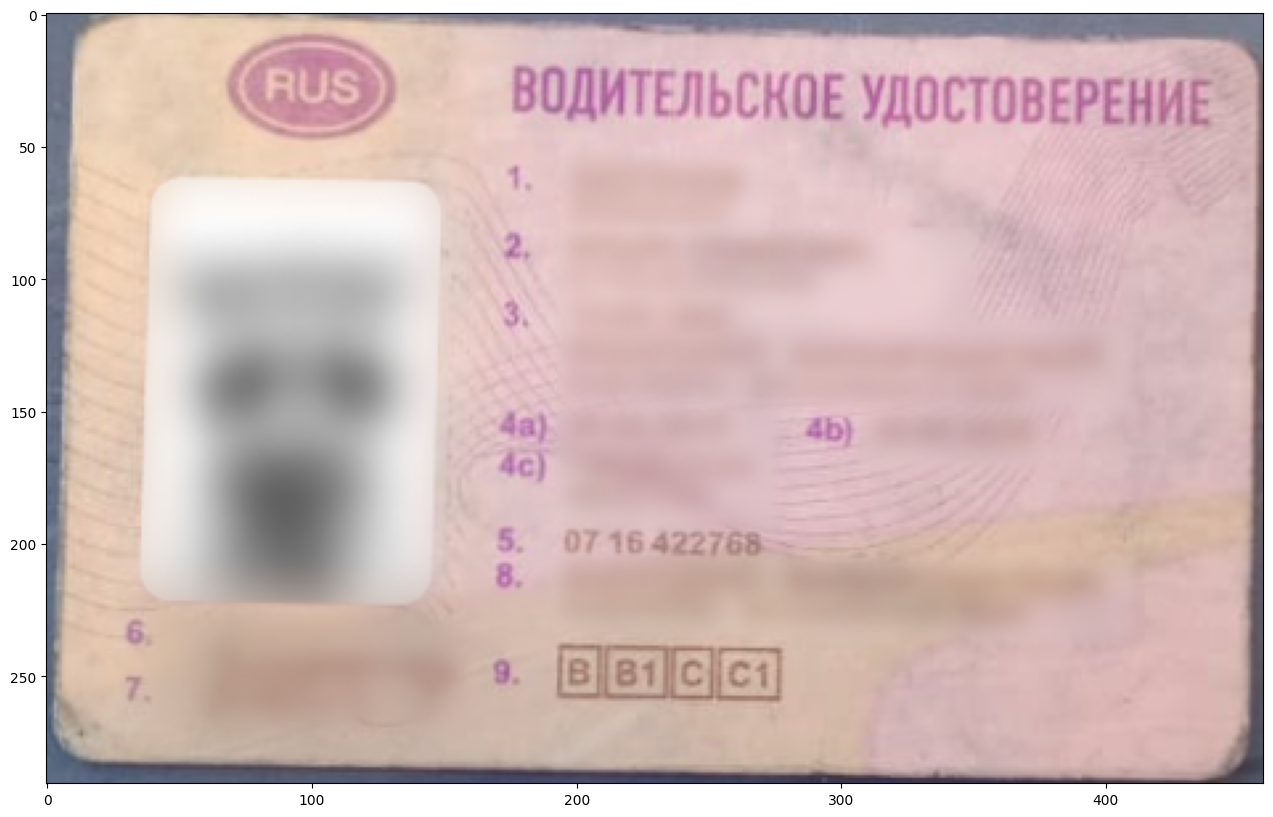

In [98]:
scanned = wrap_perspective(original.copy(), contour_to_rect(contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [244]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

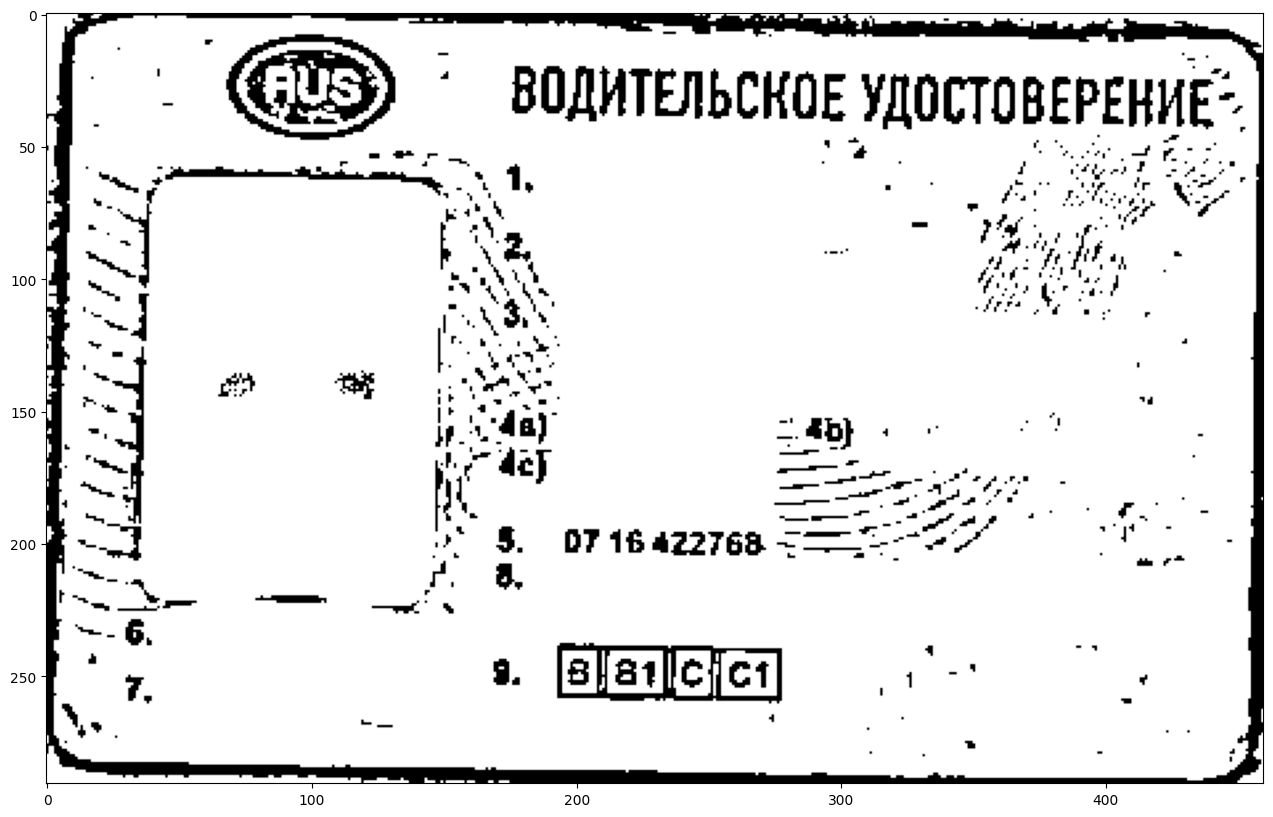

In [246]:
result = bw_scanner(scanned)
plot_gray(result)

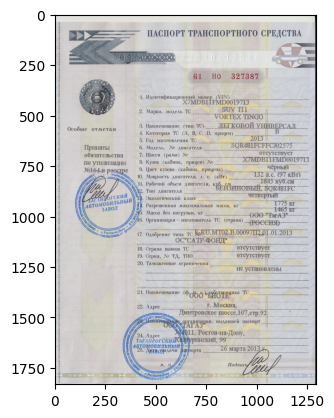

In [494]:
file_name_ocr = pts + '/Т 61 НО 327387.png'
image = cv2.imread(file_name_ocr)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [490]:
def reduce_glare(image):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    brightened = cv2.convertScaleAbs(blurred, alpha=1, beta=5)
    return brightened

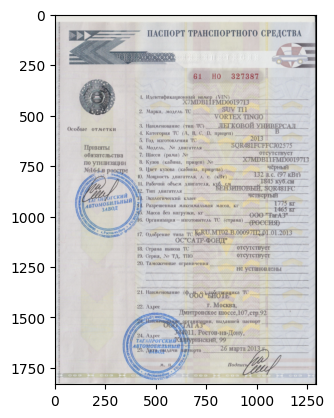

In [495]:
no_glares = reduce_glare(image)
plt.imshow(no_glares)

In [496]:
import easyocr
import pandas as pd

reader = easyocr.Reader(['ru'], gpu=True)
results = reader.readtext(no_glares)

df = pd.DataFrame(results, columns=['bbox', 'text', 'conf'])

In [497]:
df

,bbox,text,conf
0,"[[450, 68], [1224, 68], [1224, 125], [450, 125]]",ПАСПОРТ ТРАНСПОРТНОГО СРЕДСТВА,0.784004
1,"[[683, 291], [731, 291], [731, 327], [683, 327]]",61,0.933366
2,"[[773, 289], [825, 289], [825, 329], [773, 329]]",НО,0.982647
3,"[[867, 287], [1013, 287], [1013, 329], [867, 3...",327387,0.791623
4,"[[418, 398], [696, 398], [696, 428], [418, 428]]",1 Идентификашнный,0.812305
...,...,...,...
105,"[[447.0220279500418, 609.1638810551212], [494....",Тод,0.896443
106,"[[274.3273272060037, 782.1165161768104], [329....",зРАнны,0.063329
107,"[[140.94000211999364, 842.3040033919898], [174...",ПвЕА^,0.081626
108,"[[156.01985123916003, 910.601985123916], [363....",тя777гский,0.418863


In [486]:
df_conf = df.loc[df['conf'] > 0.3]
df_conf

,bbox,text,conf
0,"[[450, 68], [1224, 68], [1224, 125], [450, 125]]",ПАСПОРТ ТРАНСПОРТНОГО СРЕДСТВА,0.784004
1,"[[683, 291], [731, 291], [731, 327], [683, 327]]",61,0.933366
2,"[[773, 289], [825, 289], [825, 329], [773, 329]]",НО,0.982647
3,"[[867, 287], [1013, 287], [1013, 329], [867, 3...",327387,0.791623
4,"[[418, 398], [696, 398], [696, 428], [418, 428]]",1 Идентификашнный,0.812305
...,...,...,...
103,"[[813, 1639], [1021, 1639], [1021, 1677], [813...",26 марта 2013,0.606757
104,"[[854, 1724], [970, 1724], [970, 1750], [854, ...",По писы,0.725430
105,"[[447.0220279500418, 609.1638810551212], [494....",Тод,0.896443
108,"[[156.01985123916003, 910.601985123916], [363....",тя777гский,0.418863


In [487]:
import re

def has_no_special_chars(s):
    return re.match(r'^[.,\-\w\s:;]+$', s) is not None

In [488]:
df_res = df_conf[df_conf['text'].apply(lambda x: len(x) > 1 and has_no_special_chars(x))]
df_res

,bbox,text,conf
0,"[[450, 68], [1224, 68], [1224, 125], [450, 125]]",ПАСПОРТ ТРАНСПОРТНОГО СРЕДСТВА,0.784004
1,"[[683, 291], [731, 291], [731, 327], [683, 327]]",61,0.933366
2,"[[773, 289], [825, 289], [825, 329], [773, 329]]",НО,0.982647
3,"[[867, 287], [1013, 287], [1013, 329], [867, 3...",327387,0.791623
4,"[[418, 398], [696, 398], [696, 428], [418, 428]]",1 Идентификашнный,0.812305
...,...,...,...
103,"[[813, 1639], [1021, 1639], [1021, 1677], [813...",26 марта 2013,0.606757
104,"[[854, 1724], [970, 1724], [970, 1750], [854, ...",По писы,0.725430
105,"[[447.0220279500418, 609.1638810551212], [494....",Тод,0.896443
108,"[[156.01985123916003, 910.601985123916], [363....",тя777гский,0.418863
